In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [2]:
data= pd.read_csv('../input/bank-customer-churn-prediction/Churn_Modelling.csv', index_col='RowNumber')
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Understanding Data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Data Pre-Processing

We do not need the 'ID' and 'Surname' column in our dataset, as they won't contribute to the model as per the domain knowledge. So, dropping them :

In [5]:
data = data.drop(['CustomerId','Surname'],axis=1)

Let's perform one hot encoding on Geography and Gender

In [6]:
Geography_dummies=pd.get_dummies(data=data,columns=['Geography'])
Gender_dummies=Geography_dummies.replace(to_replace={'Gender': {'Female':1, 'Male':0}})

In [7]:
data_encoded= Gender_dummies
data_encoded.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,
1,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
2,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
3,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
4,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
5,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


# Exploratory Data Analysis

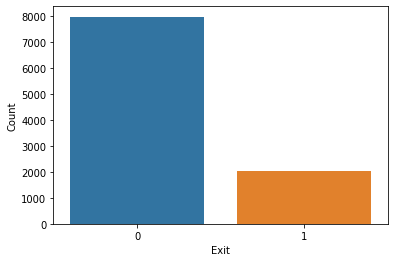

In [8]:
sns.countplot(x=data_encoded['Exited'], data= data_encoded)
plt.xlabel('Exit')
plt.ylabel('Count')
plt.show()

Checking the distribution of each feature:

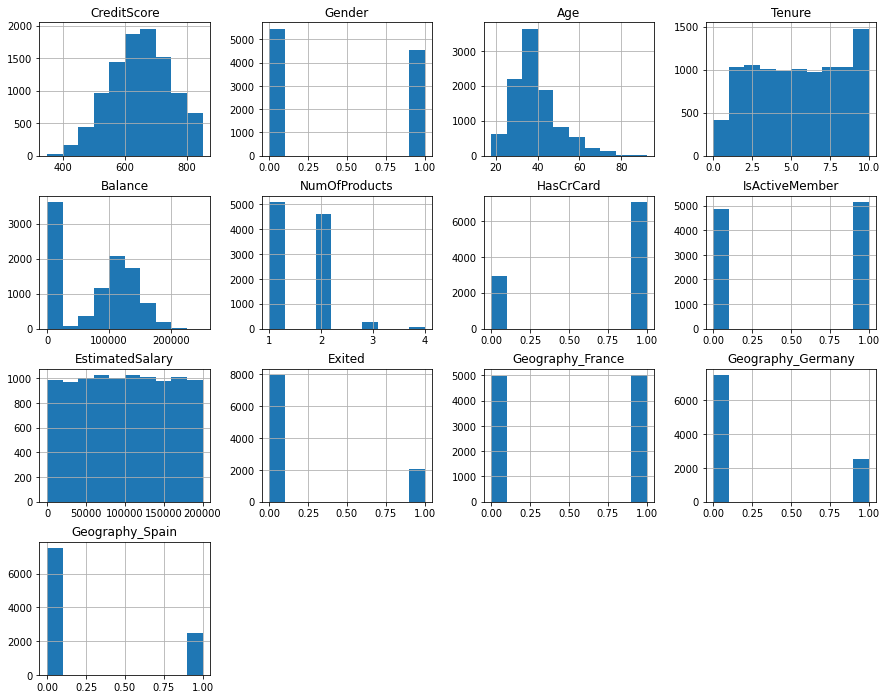

In [9]:
data_encoded.hist(figsize=(15,12))
plt.title('Features Distribution')
plt.show()

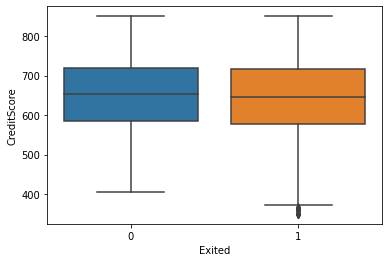

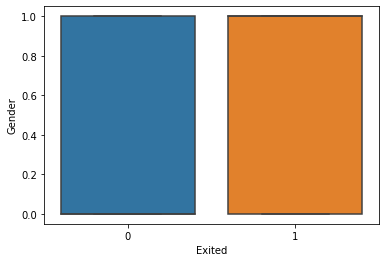

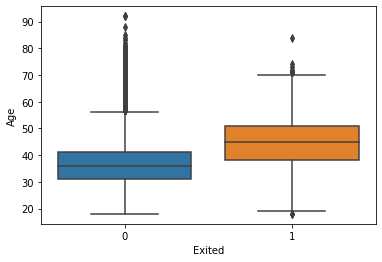

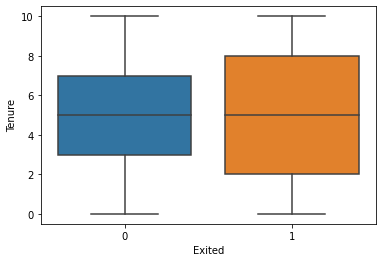

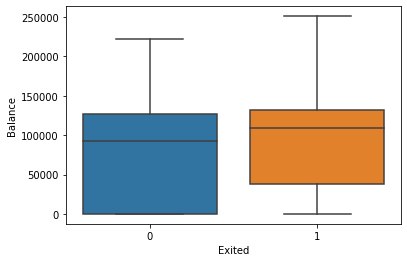

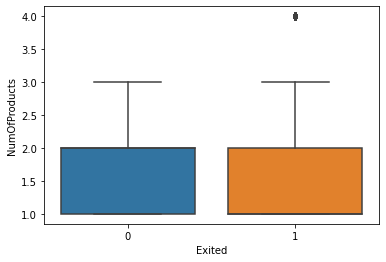

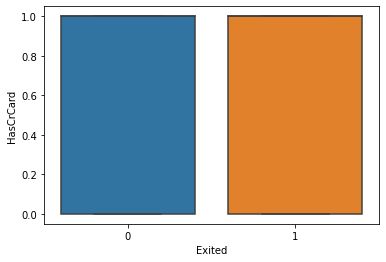

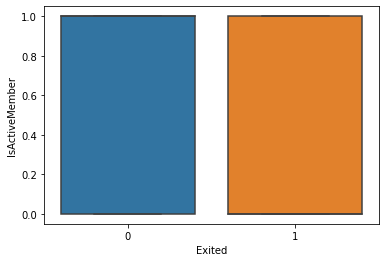

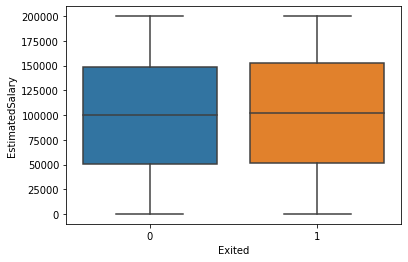

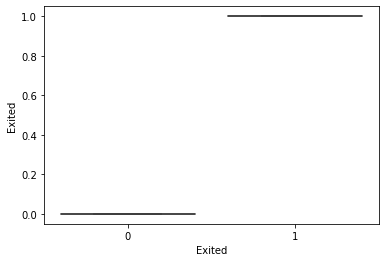

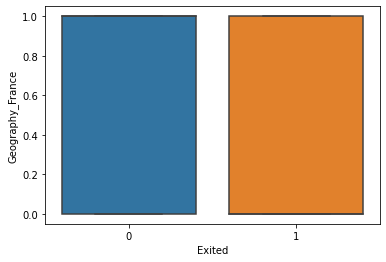

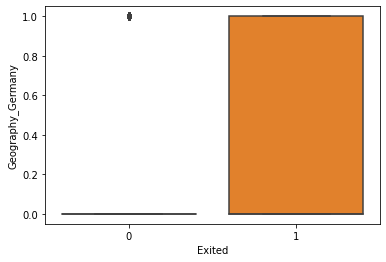

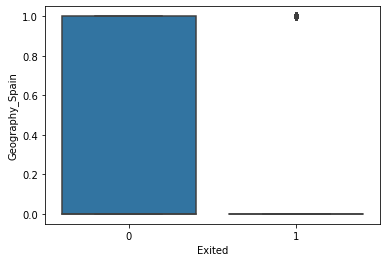

In [10]:
for i in range(0, len(data_encoded.columns)):
    sns.boxplot(x=data_encoded['Exited'],y=data_encoded.iloc[:,i], data=data_encoded)
    colname=data_encoded.columns[i]
    plt.ylabel(colname)
    plt.xlabel('Exited')
    plt.show()


# Building Model

In [11]:
X=data_encoded.drop(['Exited'], axis=1)
y=data_encoded['Exited']

In [12]:
#Performing train test split
X_train,X_test, y_train, y_test= train_test_split(X,y,test_size=0.3, random_state=0)

In [13]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
lr=LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [15]:
w=lr.coef_
w


array([[-0.09204094,  0.2641425 ,  0.74200445, -0.08328135,  0.15907678,
        -0.10809898, -0.01466387, -0.49803297,  0.03638749, -0.13651601,
         0.23457017, -0.07569012]])

In [16]:
X.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France',
       'Geography_Germany', 'Geography_Spain'],
      dtype='object')

In order to interpret these weights in terms of feature importance, there should not be any multicollinearity in the data. We will conduct a perturbation test for checking the multicollinearity.

# Perturbation Test

In [17]:
#Adding a noise to the data and retraining the model:
epsilon= 0.00005
X_new=X_train+epsilon

In [18]:
#Retraining the model
lr_perturb=LogisticRegression()
lr_perturb.fit(X_new,y_train)

w_perturb=lr_perturb.coef_
w_perturb


array([[-0.09204095,  0.26414249,  0.74200449, -0.08328136,  0.15907644,
        -0.10809916, -0.0146639 , -0.49803306,  0.03638749, -0.13660607,
         0.23449284, -0.07576787]])

In [19]:
#Adding a small number to avoid zero division:
w_perturb=w_perturb+0.000001

In [20]:
# % change
per_change=((w-w_perturb)/w)*100
per_change

array([[ 0.00108272, -0.00037489, -0.0001408 ,  0.00118938, -0.00041255,
         0.00075894,  0.00664735,  0.00018236, -0.00274113, -0.06523519,
         0.03254101, -0.10139959]])

As the last 3 columns, although have a low value but relatively high change. These columns are Geo_France, Geo_Germany and Geo_Spain, we can drop 1 out of them to avoid any redundancy in our data. Hence, dropping the one with the highest change i.e. Geo_Spain.

In [21]:
X_train_new= X_train[:,:-1]
X_train_new.shape

(7000, 11)

Checking for multicollinearity again

In [22]:
lr_2=LogisticRegression()
lr_2.fit(X_train_new,y_train)
w2=lr_2.coef_
w2

array([[-0.09204914,  0.26415302,  0.7419781 , -0.08327592,  0.15915437,
        -0.10806716, -0.01465347, -0.49802411,  0.03638854, -0.04904224,
         0.30981432]])

In [23]:
#Perturbing by adding an epsilon to X_train_new
X_pert_2=X_train_new+0.00005
lr_pert_2=LogisticRegression()
lr_pert_2.fit(X_pert_2,y_train)
w_pert=lr_pert_2.coef_
w_pert

array([[-0.09204921,  0.2641532 ,  0.74197775, -0.08327591,  0.15915424,
        -0.10806692, -0.0146534 , -0.49802426,  0.03638859, -0.04904233,
         0.30981449]])

In [24]:
#Adding small number to avoid zero division
w_pert = w_pert+0.0000001


In [25]:
# Calculating % change
change= ((w2-w_pert)/w2)*100
change

array([[ 3.70127939e-05, -1.08485266e-04,  3.36662941e-05,
         1.41330515e-04,  1.82388224e-05,  3.15164944e-04,
         1.17671686e-03, -9.27785939e-06, -4.12184902e-04,
         1.13822413e-05, -8.83149341e-05]])

**This percentage change is very small, hence it implies that there is no multicollinearity now.**

# Interpreting Feature Importance

In [26]:
dict(zip(X.columns, np.abs(w2[0].round(3))))

{'CreditScore': 0.092,
 'Gender': 0.264,
 'Age': 0.742,
 'Tenure': 0.083,
 'Balance': 0.159,
 'NumOfProducts': 0.108,
 'HasCrCard': 0.015,
 'IsActiveMember': 0.498,
 'EstimatedSalary': 0.036,
 'Geography_France': 0.049,
 'Geography_Germany': 0.31}

**Hence, as per the feature importance: 'Age','IsActiveMember','Geography_Germany','Gender' and 'Balance' are the most important feature which would help the bank decided whether a given customer would churn or not!**

# Performance Metrics

In [27]:
X_test_new= X_test[:,:-1]
lr_2.predict(X_test_new)

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
#Predict probability scores
lr_2.predict_proba(X_test_new)
#This gives 2 columns, prob(y=0), prob(y=1)

array([[0.78105505, 0.21894495],
       [0.64721188, 0.35278812],
       [0.85349726, 0.14650274],
       ...,
       [0.90764493, 0.09235507],
       [0.59081574, 0.40918426],
       [0.62148186, 0.37851814]])

**Accuracy**
Accuracy= #classified correctly/#Total
However, accuracy is not a preferred method whenever we have an imbalanced dataset, as even a dumb model can have a high accuracy.
Accuracies also does not capture the probabilistic point of view. As, even a less confident model can have the same accuracy as that of a highly confident model.

# Hyperparameter Tuning

In [29]:
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc

Tuning

In [30]:
C=[0.001, 0.005, 0.01, 0.05, 0.1,1,10,100] #inverse of regularization strength

train_auc=[]
test_auc=[]

train_logloss=[]
test_logloss=[]

for i in C:
    model= LogisticRegression(penalty='l2', C=i, solver='liblinear')
    model.fit(X_train_new, y_train)
    y_train_pred= model.predict(X_train_new)
    y_test_pred= model.predict(X_test_new)
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test,y_test_pred))
    
    train_logloss.append(log_loss(y_train,y_train_pred))
    test_logloss.append(log_loss(y_test,y_test_pred))

Plotting AUC for train and test

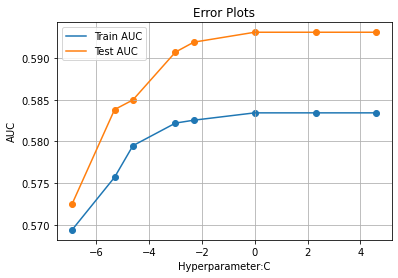

In [31]:
plt.grid(True)
plt.plot(np.log(C), train_auc, label='Train AUC')
plt.plot(np.log(C), test_auc, label='Test AUC')
plt.scatter(np.log(C), train_auc)
plt.scatter(np.log(C), test_auc)
plt.legend()
plt.xlabel('Hyperparameter:C')
plt.ylabel('AUC')
plt.title('Error Plots')
plt.show()


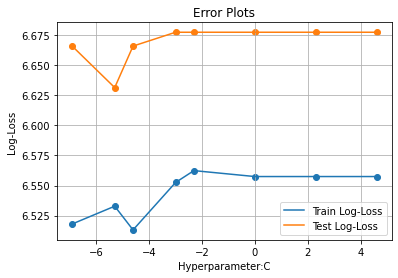

In [32]:
plt.grid(True)
plt.plot(np.log(C), train_logloss, label='Train Log-Loss')
plt.plot(np.log(C), test_logloss, label='Test Log-Loss')
plt.scatter(np.log(C), train_logloss)
plt.scatter(np.log(C), test_logloss)
plt.legend()
plt.xlabel('Hyperparameter:C')
plt.ylabel('Log-Loss')
plt.title('Error Plots')
plt.show()

We choose C=0.005

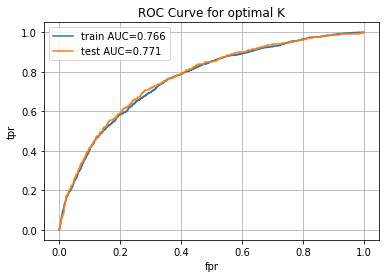

In [33]:
model= LogisticRegression(penalty='l2', C=0.005, solver='liblinear')
model.fit(X_train_new, y_train)
y_train_pred= model.predict(X_train_new)
y_test_pred= model.predict(X_test_new)
train_fpr, train_tpr, thresholds= roc_curve(y_train,model.predict_proba(X_train_new)[:,1])
test_fpr, test_tpr, thresholds= roc_curve(y_test,model.predict_proba(X_test_new)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label='train AUC='+str(auc(train_fpr,train_tpr).round(3)))
plt.plot(test_fpr, test_tpr, label='test AUC='+str(auc(test_fpr,test_tpr).round(3)))
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for optimal K')
plt.show()

# Performance Metrics

In [34]:
y_probs=model.predict_proba(X_test_new)
df_proba=pd.DataFrame(y_probs, columns=['p-0','p-1'])
print("Predictions: ", y_test_pred[:10])
print(df_proba)

Predictions:  [0 0 0 0 0 1 0 0 0 1]
           p-0       p-1
0     0.719871  0.280129
1     0.640032  0.359968
2     0.788934  0.211066
3     0.830523  0.169477
4     0.785972  0.214028
...        ...       ...
2995  0.808818  0.191182
2996  0.521619  0.478381
2997  0.852999  0.147001
2998  0.581157  0.418843
2999  0.593831  0.406169

[3000 rows x 2 columns]


**1.Accuracy**

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve

In [36]:
#Testing the performance of our logistic regression model
accuracy= accuracy_score(y_test,y_test_pred)
print(accuracy.round(3))

0.808


**2. Confusion Matrix**

In [37]:
results=confusion_matrix(y_test, y_test_pred)
print(results)

[[2299   80]
 [ 496  125]]


**Full Classification report**

In [38]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      2379
           1       0.61      0.20      0.30       621

    accuracy                           0.81      3000
   macro avg       0.72      0.58      0.60      3000
weighted avg       0.78      0.81      0.77      3000



**ROC Area**

In [39]:
roc_auc_score(y_test, y_probs[:,1]).round(4)

0.771

**LOG LOSS**

In [40]:
log_loss(y_test, y_probs[:,1])

0.4406041819063359